# Column generation approach

## Pre-requisites

In [1]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

from src import cg, config, dataset, layers, pack, superitems, utils, warm_start

In [2]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Dataset

In [4]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,160,280,233,8,10438400
1,199,269,260,11,13918060
2,187,101,283,2,5345021
3,126,149,214,2,4017636
4,248,132,280,3,9166080


<IPython.core.display.Javascript object>

In [30]:
ordered_products = 100
order = product_dataset.get_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,214176,245,139,292,3,9944060
1,184779,241,158,342,2,13022676
2,347449,268,313,456,13,38251104
3,421909,231,176,329,30,13375824
4,989436,363,151,487,2,26693931


<IPython.core.display.Javascript object>

In [6]:
order = pd.concat([order.sample(4)] * 5).reset_index(drop=True)
order.head()

,id,width,depth,height,weight,volume
0,121958,193,221,371,2,15824263
1,671155,236,142,437,58,14644744
2,54886,249,142,388,3,13718904
3,644167,286,158,481,6,21735428
4,121958,193,221,371,2,15824263


<IPython.core.display.Javascript object>

In [18]:
order = order.sample(100).reset_index(drop=True)
order["height"] = 400
order.head()

ValueError: Cannot take a larger sample than population when 'replace=False'

<IPython.core.display.Javascript object>

## Martello's lower bounds

In [8]:
utils.get_l0_lb(order, config.PALLET_DIMS)

1.0

<IPython.core.display.Javascript object>

In [9]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [10]:
utils.get_l2_lb(order, config.PALLET_DIMS)

TypeError: get_l1_lb() takes 2 positional arguments but 4 were given

<IPython.core.display.Javascript object>

## Superitems

In [36]:
superitems_pool = superitems.SuperitemPool(
    order=order, pallet_dims=config.PALLET_DIMS, max_vstacked=4, not_horizontal=True
)
superitems_pool.to_dataframe()

Generating vertical superitems: 100%|██████████| 28/28 [00:00<00:00, 359145.30it/s]


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,241,158,342,[1],SingleItemSuperitem
2,268,313,456,[2],SingleItemSuperitem
3,231,176,329,[3],SingleItemSuperitem
4,363,151,487,[4],SingleItemSuperitem
...,...,...,...,...,...
201,196,242,1053,"[11, 74, 77, 89]",VerticalSuperitem
202,222,269,1222,"[44, 67, 79, 95]",VerticalSuperitem
203,237,291,1306,"[13, 38, 69, 84]",VerticalSuperitem
204,268,318,1589,"[2, 23, 40, 41]",VerticalSuperitem


<IPython.core.display.Javascript object>

In [37]:
df = superitems_pool.to_dataframe()
df[df["type"].str.contains("Vertical")]

,width,depth,height,ids,type
100,151,141,516,"[49, 73]",VerticalSuperitem
101,160,111,525,"[16, 75]",VerticalSuperitem
102,176,155,503,"[55, 65]",VerticalSuperitem
103,177,175,537,"[78, 91]",VerticalSuperitem
104,178,174,421,"[15, 24]",VerticalSuperitem
...,...,...,...,...,...
201,196,242,1053,"[11, 74, 77, 89]",VerticalSuperitem
202,222,269,1222,"[44, 67, 79, 95]",VerticalSuperitem
203,237,291,1306,"[13, 38, 69, 84]",VerticalSuperitem
204,268,318,1589,"[2, 23, 40, 41]",VerticalSuperitem


<IPython.core.display.Javascript object>

In [9]:
df = superitems_pool.to_dataframe()
df[df["type"].str.contains("Horizontal")]

,width,depth,height,ids,type


<IPython.core.display.Javascript object>

## Height groups

In [52]:
height_groups = warm_start.get_height_groups(
    superitems_pool, config.PALLET_DIMS, height_tol=50, density_tol=0.0
)
for group in height_groups:
    display(group.to_dataframe())

,width,depth,height,ids,type
0,155,205,176,[11],SingleItemSuperitem
1,110,183,139,[98],SingleItemSuperitem


,width,depth,height,ids,type
0,155,205,176,[11],SingleItemSuperitem
1,168,173,224,[12],SingleItemSuperitem
2,178,83,195,[15],SingleItemSuperitem
3,177,174,226,[24],SingleItemSuperitem
4,192,132,201,[34],SingleItemSuperitem
5,179,176,225,[50],SingleItemSuperitem
6,140,174,223,[60],SingleItemSuperitem
7,190,91,215,[68],SingleItemSuperitem


,width,depth,height,ids,type
0,168,173,224,[12],SingleItemSuperitem
1,178,83,195,[15],SingleItemSuperitem
2,177,174,226,[24],SingleItemSuperitem
3,123,159,227,[28],SingleItemSuperitem
4,192,132,201,[34],SingleItemSuperitem
5,135,130,228,[49],SingleItemSuperitem
6,179,176,225,[50],SingleItemSuperitem
7,140,174,223,[60],SingleItemSuperitem
8,163,155,239,[65],SingleItemSuperitem
9,190,91,215,[68],SingleItemSuperitem


,width,depth,height,ids,type
0,168,173,224,[12],SingleItemSuperitem
1,177,174,226,[24],SingleItemSuperitem
2,123,159,227,[28],SingleItemSuperitem
3,192,132,201,[34],SingleItemSuperitem
4,234,112,251,[39],SingleItemSuperitem
5,135,130,228,[49],SingleItemSuperitem
6,179,176,225,[50],SingleItemSuperitem
7,140,174,223,[60],SingleItemSuperitem
8,163,155,239,[65],SingleItemSuperitem
9,190,91,215,[68],SingleItemSuperitem


,width,depth,height,ids,type
0,168,173,224,[12],SingleItemSuperitem
1,188,371,257,[18],SingleItemSuperitem
2,177,174,226,[24],SingleItemSuperitem
3,123,159,227,[28],SingleItemSuperitem
4,234,112,251,[39],SingleItemSuperitem
5,135,130,228,[49],SingleItemSuperitem
6,179,176,225,[50],SingleItemSuperitem
7,223,136,257,[54],SingleItemSuperitem
8,176,98,264,[55],SingleItemSuperitem
9,140,174,223,[60],SingleItemSuperitem


,width,depth,height,ids,type
0,218,54,267,[6],SingleItemSuperitem
1,168,173,224,[12],SingleItemSuperitem
2,188,371,257,[18],SingleItemSuperitem
3,177,174,226,[24],SingleItemSuperitem
4,123,159,227,[28],SingleItemSuperitem
5,234,112,251,[39],SingleItemSuperitem
6,135,130,228,[49],SingleItemSuperitem
7,179,176,225,[50],SingleItemSuperitem
8,223,136,257,[54],SingleItemSuperitem
9,176,98,264,[55],SingleItemSuperitem


,width,depth,height,ids,type
0,218,54,267,[6],SingleItemSuperitem
1,188,371,257,[18],SingleItemSuperitem
2,177,174,226,[24],SingleItemSuperitem
3,123,159,227,[28],SingleItemSuperitem
4,234,112,251,[39],SingleItemSuperitem
5,135,130,228,[49],SingleItemSuperitem
6,179,176,225,[50],SingleItemSuperitem
7,223,136,257,[54],SingleItemSuperitem
8,176,98,264,[55],SingleItemSuperitem
9,197,382,268,[56],SingleItemSuperitem


,width,depth,height,ids,type
0,218,54,267,[6],SingleItemSuperitem
1,188,371,257,[18],SingleItemSuperitem
2,123,159,227,[28],SingleItemSuperitem
3,234,112,251,[39],SingleItemSuperitem
4,135,130,228,[49],SingleItemSuperitem
5,223,136,257,[54],SingleItemSuperitem
6,176,98,264,[55],SingleItemSuperitem
7,197,382,268,[56],SingleItemSuperitem
8,163,155,239,[65],SingleItemSuperitem
9,165,251,275,[67],SingleItemSuperitem


,width,depth,height,ids,type
0,218,54,267,[6],SingleItemSuperitem
1,226,269,279,[13],SingleItemSuperitem
2,159,92,279,[16],SingleItemSuperitem
3,188,371,257,[18],SingleItemSuperitem
4,238,345,289,[29],SingleItemSuperitem
5,187,144,281,[32],SingleItemSuperitem
6,269,144,283,[33],SingleItemSuperitem
7,242,109,289,[35],SingleItemSuperitem
8,234,112,251,[39],SingleItemSuperitem
9,159,304,281,[40],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,218,54,267,[6],SingleItemSuperitem
2,226,269,279,[13],SingleItemSuperitem
3,159,92,279,[16],SingleItemSuperitem
4,188,371,257,[18],SingleItemSuperitem
5,238,345,289,[29],SingleItemSuperitem
6,187,144,281,[32],SingleItemSuperitem
7,269,144,283,[33],SingleItemSuperitem
8,242,109,289,[35],SingleItemSuperitem
9,234,112,251,[39],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,218,54,267,[6],SingleItemSuperitem
2,226,269,279,[13],SingleItemSuperitem
3,159,92,279,[16],SingleItemSuperitem
4,188,371,257,[18],SingleItemSuperitem
5,238,345,289,[29],SingleItemSuperitem
6,187,144,281,[32],SingleItemSuperitem
7,269,144,283,[33],SingleItemSuperitem
8,242,109,289,[35],SingleItemSuperitem
9,234,112,251,[39],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,218,54,267,[6],SingleItemSuperitem
2,226,269,279,[13],SingleItemSuperitem
3,159,92,279,[16],SingleItemSuperitem
4,188,371,257,[18],SingleItemSuperitem
5,238,345,289,[29],SingleItemSuperitem
6,187,144,281,[32],SingleItemSuperitem
7,269,144,283,[33],SingleItemSuperitem
8,242,109,289,[35],SingleItemSuperitem
9,240,97,304,[37],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,218,54,267,[6],SingleItemSuperitem
2,226,269,279,[13],SingleItemSuperitem
3,159,92,279,[16],SingleItemSuperitem
4,238,345,289,[29],SingleItemSuperitem
5,187,144,281,[32],SingleItemSuperitem
6,269,144,283,[33],SingleItemSuperitem
7,242,109,289,[35],SingleItemSuperitem
8,240,97,304,[37],SingleItemSuperitem
9,159,304,281,[40],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,218,54,267,[6],SingleItemSuperitem
2,226,269,279,[13],SingleItemSuperitem
3,159,92,279,[16],SingleItemSuperitem
4,213,188,313,[19],SingleItemSuperitem
5,238,345,289,[29],SingleItemSuperitem
6,187,144,281,[32],SingleItemSuperitem
7,269,144,283,[33],SingleItemSuperitem
8,242,109,289,[35],SingleItemSuperitem
9,240,97,304,[37],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,273,257,325,[9],SingleItemSuperitem
2,226,269,279,[13],SingleItemSuperitem
3,159,92,279,[16],SingleItemSuperitem
4,213,188,313,[19],SingleItemSuperitem
5,238,345,289,[29],SingleItemSuperitem
6,187,144,281,[32],SingleItemSuperitem
7,269,144,283,[33],SingleItemSuperitem
8,242,109,289,[35],SingleItemSuperitem
9,240,97,304,[37],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,273,257,325,[9],SingleItemSuperitem
2,226,269,279,[13],SingleItemSuperitem
3,159,92,279,[16],SingleItemSuperitem
4,213,188,313,[19],SingleItemSuperitem
5,238,345,289,[29],SingleItemSuperitem
6,225,93,327,[31],SingleItemSuperitem
7,187,144,281,[32],SingleItemSuperitem
8,269,144,283,[33],SingleItemSuperitem
9,242,109,289,[35],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,226,269,279,[13],SingleItemSuperitem
4,159,92,279,[16],SingleItemSuperitem
5,213,188,313,[19],SingleItemSuperitem
6,238,345,289,[29],SingleItemSuperitem
7,225,93,327,[31],SingleItemSuperitem
8,187,144,281,[32],SingleItemSuperitem
9,269,144,283,[33],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,213,188,313,[19],SingleItemSuperitem
4,238,345,289,[29],SingleItemSuperitem
5,225,93,327,[31],SingleItemSuperitem
6,187,144,281,[32],SingleItemSuperitem
7,269,144,283,[33],SingleItemSuperitem
8,242,109,289,[35],SingleItemSuperitem
9,240,97,304,[37],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,213,188,313,[19],SingleItemSuperitem
4,287,157,333,[22],SingleItemSuperitem
5,244,312,333,[23],SingleItemSuperitem
6,238,345,289,[29],SingleItemSuperitem
7,225,93,327,[31],SingleItemSuperitem
8,269,144,283,[33],SingleItemSuperitem
9,242,109,289,[35],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,213,188,313,[19],SingleItemSuperitem
4,287,157,333,[22],SingleItemSuperitem
5,244,312,333,[23],SingleItemSuperitem
6,238,345,289,[29],SingleItemSuperitem
7,225,93,327,[31],SingleItemSuperitem
8,242,109,289,[35],SingleItemSuperitem
9,240,97,304,[37],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,241,158,342,[1],SingleItemSuperitem
2,231,176,329,[3],SingleItemSuperitem
3,273,257,325,[9],SingleItemSuperitem
4,213,188,313,[19],SingleItemSuperitem
5,287,157,333,[22],SingleItemSuperitem
6,244,312,333,[23],SingleItemSuperitem
7,225,93,327,[31],SingleItemSuperitem
8,240,97,304,[37],SingleItemSuperitem
9,217,244,313,[44],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,213,188,313,[19],SingleItemSuperitem
4,287,157,333,[22],SingleItemSuperitem
5,244,312,333,[23],SingleItemSuperitem
6,225,93,327,[31],SingleItemSuperitem
7,240,97,304,[37],SingleItemSuperitem
8,217,244,313,[44],SingleItemSuperitem
9,180,64,336,[57],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,186,378,351,[14],SingleItemSuperitem
4,213,188,313,[19],SingleItemSuperitem
5,287,157,333,[22],SingleItemSuperitem
6,244,312,333,[23],SingleItemSuperitem
7,239,159,354,[30],SingleItemSuperitem
8,225,93,327,[31],SingleItemSuperitem
9,241,231,350,[36],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,186,378,351,[14],SingleItemSuperitem
4,213,188,313,[19],SingleItemSuperitem
5,287,157,333,[22],SingleItemSuperitem
6,244,312,333,[23],SingleItemSuperitem
7,239,159,354,[30],SingleItemSuperitem
8,225,93,327,[31],SingleItemSuperitem
9,241,231,350,[36],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,186,378,351,[14],SingleItemSuperitem
4,213,188,313,[19],SingleItemSuperitem
5,287,157,333,[22],SingleItemSuperitem
6,244,312,333,[23],SingleItemSuperitem
7,239,159,354,[30],SingleItemSuperitem
8,225,93,327,[31],SingleItemSuperitem
9,241,231,350,[36],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,186,378,351,[14],SingleItemSuperitem
4,287,157,333,[22],SingleItemSuperitem
5,244,312,333,[23],SingleItemSuperitem
6,239,159,354,[30],SingleItemSuperitem
7,225,93,327,[31],SingleItemSuperitem
8,241,231,350,[36],SingleItemSuperitem
9,207,282,352,[38],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,186,378,351,[14],SingleItemSuperitem
4,287,157,333,[22],SingleItemSuperitem
5,244,312,333,[23],SingleItemSuperitem
6,239,159,354,[30],SingleItemSuperitem
7,225,93,327,[31],SingleItemSuperitem
8,241,231,350,[36],SingleItemSuperitem
9,207,282,352,[38],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,186,378,351,[14],SingleItemSuperitem
3,287,157,333,[22],SingleItemSuperitem
4,244,312,333,[23],SingleItemSuperitem
5,239,159,354,[30],SingleItemSuperitem
6,225,93,327,[31],SingleItemSuperitem
7,241,231,350,[36],SingleItemSuperitem
8,207,282,352,[38],SingleItemSuperitem
9,302,121,376,[47],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,186,378,351,[14],SingleItemSuperitem
3,287,157,333,[22],SingleItemSuperitem
4,244,312,333,[23],SingleItemSuperitem
5,239,159,354,[30],SingleItemSuperitem
6,241,231,350,[36],SingleItemSuperitem
7,207,282,352,[38],SingleItemSuperitem
8,302,121,376,[47],SingleItemSuperitem
9,286,191,379,[53],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,186,378,351,[14],SingleItemSuperitem
2,287,157,333,[22],SingleItemSuperitem
3,244,312,333,[23],SingleItemSuperitem
4,239,159,354,[30],SingleItemSuperitem
5,241,231,350,[36],SingleItemSuperitem
6,207,282,352,[38],SingleItemSuperitem
7,275,171,380,[45],SingleItemSuperitem
8,302,121,376,[47],SingleItemSuperitem
9,286,191,379,[53],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,186,378,351,[14],SingleItemSuperitem
2,239,159,354,[30],SingleItemSuperitem
3,241,231,350,[36],SingleItemSuperitem
4,207,282,352,[38],SingleItemSuperitem
5,275,171,380,[45],SingleItemSuperitem
6,307,187,387,[46],SingleItemSuperitem
7,302,121,376,[47],SingleItemSuperitem
8,286,191,379,[53],SingleItemSuperitem
9,235,155,372,[59],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,186,378,351,[14],SingleItemSuperitem
2,239,159,354,[30],SingleItemSuperitem
3,241,231,350,[36],SingleItemSuperitem
4,207,282,352,[38],SingleItemSuperitem
5,275,171,380,[45],SingleItemSuperitem
6,307,187,387,[46],SingleItemSuperitem
7,302,121,376,[47],SingleItemSuperitem
8,286,191,379,[53],SingleItemSuperitem
9,235,155,372,[59],SingleItemSuperitem


,width,depth,height,ids,type
0,186,378,351,[14],SingleItemSuperitem
1,219,205,393,[26],SingleItemSuperitem
2,239,159,354,[30],SingleItemSuperitem
3,241,231,350,[36],SingleItemSuperitem
4,207,282,352,[38],SingleItemSuperitem
5,275,171,380,[45],SingleItemSuperitem
6,307,187,387,[46],SingleItemSuperitem
7,302,121,376,[47],SingleItemSuperitem
8,286,191,379,[53],SingleItemSuperitem
9,235,155,372,[59],SingleItemSuperitem


,width,depth,height,ids,type
0,186,378,351,[14],SingleItemSuperitem
1,219,205,393,[26],SingleItemSuperitem
2,239,159,354,[30],SingleItemSuperitem
3,241,231,350,[36],SingleItemSuperitem
4,207,282,352,[38],SingleItemSuperitem
5,275,171,380,[45],SingleItemSuperitem
6,307,187,387,[46],SingleItemSuperitem
7,302,121,376,[47],SingleItemSuperitem
8,239,119,398,[51],SingleItemSuperitem
9,286,191,379,[53],SingleItemSuperitem


,width,depth,height,ids,type
0,186,378,351,[14],SingleItemSuperitem
1,219,205,393,[26],SingleItemSuperitem
2,239,159,354,[30],SingleItemSuperitem
3,207,282,352,[38],SingleItemSuperitem
4,275,171,380,[45],SingleItemSuperitem
5,307,187,387,[46],SingleItemSuperitem
6,302,121,376,[47],SingleItemSuperitem
7,284,197,401,[48],SingleItemSuperitem
8,239,119,398,[51],SingleItemSuperitem
9,286,191,379,[53],SingleItemSuperitem


,width,depth,height,ids,type
0,247,133,403,[7],SingleItemSuperitem
1,219,205,393,[26],SingleItemSuperitem
2,239,159,354,[30],SingleItemSuperitem
3,275,171,380,[45],SingleItemSuperitem
4,307,187,387,[46],SingleItemSuperitem
5,302,121,376,[47],SingleItemSuperitem
6,284,197,401,[48],SingleItemSuperitem
7,239,119,398,[51],SingleItemSuperitem
8,286,191,379,[53],SingleItemSuperitem
9,235,155,372,[59],SingleItemSuperitem


,width,depth,height,ids,type
0,243,102,406,[5],SingleItemSuperitem
1,247,133,403,[7],SingleItemSuperitem
2,219,205,393,[26],SingleItemSuperitem
3,275,171,380,[45],SingleItemSuperitem
4,307,187,387,[46],SingleItemSuperitem
5,302,121,376,[47],SingleItemSuperitem
6,284,197,401,[48],SingleItemSuperitem
7,239,119,398,[51],SingleItemSuperitem
8,286,191,379,[53],SingleItemSuperitem
9,235,155,372,[59],SingleItemSuperitem


,width,depth,height,ids,type
0,243,102,406,[5],SingleItemSuperitem
1,247,133,403,[7],SingleItemSuperitem
2,340,192,413,[8],SingleItemSuperitem
3,219,205,393,[26],SingleItemSuperitem
4,275,171,380,[45],SingleItemSuperitem
5,307,187,387,[46],SingleItemSuperitem
6,302,121,376,[47],SingleItemSuperitem
7,284,197,401,[48],SingleItemSuperitem
8,239,119,398,[51],SingleItemSuperitem
9,286,191,379,[53],SingleItemSuperitem


,width,depth,height,ids,type
0,243,102,406,[5],SingleItemSuperitem
1,247,133,403,[7],SingleItemSuperitem
2,340,192,413,[8],SingleItemSuperitem
3,307,167,422,[10],SingleItemSuperitem
4,219,205,393,[26],SingleItemSuperitem
5,339,84,417,[27],SingleItemSuperitem
6,275,171,380,[45],SingleItemSuperitem
7,307,187,387,[46],SingleItemSuperitem
8,302,121,376,[47],SingleItemSuperitem
9,284,197,401,[48],SingleItemSuperitem


,width,depth,height,ids,type
0,243,102,406,[5],SingleItemSuperitem
1,247,133,403,[7],SingleItemSuperitem
2,340,192,413,[8],SingleItemSuperitem
3,307,167,422,[10],SingleItemSuperitem
4,219,205,393,[26],SingleItemSuperitem
5,339,84,417,[27],SingleItemSuperitem
6,275,171,380,[45],SingleItemSuperitem
7,307,187,387,[46],SingleItemSuperitem
8,284,197,401,[48],SingleItemSuperitem
9,239,119,398,[51],SingleItemSuperitem


,width,depth,height,ids,type
0,243,102,406,[5],SingleItemSuperitem
1,247,133,403,[7],SingleItemSuperitem
2,340,192,413,[8],SingleItemSuperitem
3,307,167,422,[10],SingleItemSuperitem
4,350,287,441,[25],SingleItemSuperitem
5,219,205,393,[26],SingleItemSuperitem
6,339,84,417,[27],SingleItemSuperitem
7,284,197,401,[48],SingleItemSuperitem
8,239,119,398,[51],SingleItemSuperitem
9,237,273,391,[69],SingleItemSuperitem


,width,depth,height,ids,type
0,243,102,406,[5],SingleItemSuperitem
1,247,133,403,[7],SingleItemSuperitem
2,340,192,413,[8],SingleItemSuperitem
3,307,167,422,[10],SingleItemSuperitem
4,350,287,441,[25],SingleItemSuperitem
5,219,205,393,[26],SingleItemSuperitem
6,339,84,417,[27],SingleItemSuperitem
7,284,197,401,[48],SingleItemSuperitem
8,239,119,398,[51],SingleItemSuperitem
9,362,186,443,[72],SingleItemSuperitem


,width,depth,height,ids,type
0,243,102,406,[5],SingleItemSuperitem
1,247,133,403,[7],SingleItemSuperitem
2,340,192,413,[8],SingleItemSuperitem
3,307,167,422,[10],SingleItemSuperitem
4,300,291,444,[20],SingleItemSuperitem
5,350,287,441,[25],SingleItemSuperitem
6,339,84,417,[27],SingleItemSuperitem
7,284,197,401,[48],SingleItemSuperitem
8,239,119,398,[51],SingleItemSuperitem
9,254,179,448,[61],SingleItemSuperitem


,width,depth,height,ids,type
0,243,102,406,[5],SingleItemSuperitem
1,247,133,403,[7],SingleItemSuperitem
2,340,192,413,[8],SingleItemSuperitem
3,307,167,422,[10],SingleItemSuperitem
4,300,291,444,[20],SingleItemSuperitem
5,350,287,441,[25],SingleItemSuperitem
6,339,84,417,[27],SingleItemSuperitem
7,284,197,401,[48],SingleItemSuperitem
8,254,179,448,[61],SingleItemSuperitem
9,362,186,443,[72],SingleItemSuperitem


,width,depth,height,ids,type
0,268,313,456,[2],SingleItemSuperitem
1,243,102,406,[5],SingleItemSuperitem
2,340,192,413,[8],SingleItemSuperitem
3,307,167,422,[10],SingleItemSuperitem
4,300,291,444,[20],SingleItemSuperitem
5,350,287,441,[25],SingleItemSuperitem
6,339,84,417,[27],SingleItemSuperitem
7,254,179,448,[61],SingleItemSuperitem
8,362,186,443,[72],SingleItemSuperitem
9,375,202,440,[99],SingleItemSuperitem


,width,depth,height,ids,type
0,268,313,456,[2],SingleItemSuperitem
1,307,167,422,[10],SingleItemSuperitem
2,300,291,444,[20],SingleItemSuperitem
3,350,287,441,[25],SingleItemSuperitem
4,254,179,448,[61],SingleItemSuperitem
5,362,186,443,[72],SingleItemSuperitem
6,277,359,468,[81],SingleItemSuperitem
7,375,202,440,[99],SingleItemSuperitem
8,178,174,421,"[15, 24]",VerticalSuperitem
9,168,173,451,"[12, 28]",VerticalSuperitem


,width,depth,height,ids,type
0,268,313,456,[2],SingleItemSuperitem
1,307,167,422,[10],SingleItemSuperitem
2,324,98,472,[17],SingleItemSuperitem
3,300,291,444,[20],SingleItemSuperitem
4,350,287,441,[25],SingleItemSuperitem
5,254,179,448,[61],SingleItemSuperitem
6,362,186,443,[72],SingleItemSuperitem
7,277,359,468,[81],SingleItemSuperitem
8,375,202,440,[99],SingleItemSuperitem
9,168,173,451,"[12, 28]",VerticalSuperitem


,width,depth,height,ids,type
0,268,313,456,[2],SingleItemSuperitem
1,363,151,487,[4],SingleItemSuperitem
2,324,98,472,[17],SingleItemSuperitem
3,300,291,444,[20],SingleItemSuperitem
4,317,110,484,[21],SingleItemSuperitem
5,350,287,441,[25],SingleItemSuperitem
6,254,179,448,[61],SingleItemSuperitem
7,299,121,486,[66],SingleItemSuperitem
8,362,186,443,[72],SingleItemSuperitem
9,277,359,468,[81],SingleItemSuperitem


,width,depth,height,ids,type
0,268,313,456,[2],SingleItemSuperitem
1,363,151,487,[4],SingleItemSuperitem
2,324,98,472,[17],SingleItemSuperitem
3,317,110,484,[21],SingleItemSuperitem
4,254,179,448,[61],SingleItemSuperitem
5,299,121,486,[66],SingleItemSuperitem
6,277,359,468,[81],SingleItemSuperitem
7,190,144,496,"[32, 68]",VerticalSuperitem
8,168,173,451,"[12, 28]",VerticalSuperitem


,width,depth,height,ids,type
0,268,313,456,[2],SingleItemSuperitem
1,363,151,487,[4],SingleItemSuperitem
2,324,98,472,[17],SingleItemSuperitem
3,317,110,484,[21],SingleItemSuperitem
4,299,121,486,[66],SingleItemSuperitem
5,277,359,468,[81],SingleItemSuperitem
6,176,155,503,"[55, 65]",VerticalSuperitem
7,190,144,496,"[32, 68]",VerticalSuperitem


,width,depth,height,ids,type
0,363,151,487,[4],SingleItemSuperitem
1,324,98,472,[17],SingleItemSuperitem
2,317,110,484,[21],SingleItemSuperitem
3,281,69,510,[43],SingleItemSuperitem
4,299,121,486,[66],SingleItemSuperitem
5,277,359,468,[81],SingleItemSuperitem
6,151,141,516,"[49, 73]",VerticalSuperitem
7,176,155,503,"[55, 65]",VerticalSuperitem
8,190,144,496,"[32, 68]",VerticalSuperitem
9,196,135,511,"[34, 92]",VerticalSuperitem


,width,depth,height,ids,type
0,363,151,487,[4],SingleItemSuperitem
1,324,98,472,[17],SingleItemSuperitem
2,317,110,484,[21],SingleItemSuperitem
3,225,318,519,[41],SingleItemSuperitem
4,281,69,510,[43],SingleItemSuperitem
5,299,121,486,[66],SingleItemSuperitem
6,151,141,516,"[49, 73]",VerticalSuperitem
7,176,155,503,"[55, 65]",VerticalSuperitem
8,190,144,496,"[32, 68]",VerticalSuperitem
9,196,135,511,"[34, 92]",VerticalSuperitem


,width,depth,height,ids,type
0,363,151,487,[4],SingleItemSuperitem
1,317,110,484,[21],SingleItemSuperitem
2,225,318,519,[41],SingleItemSuperitem
3,281,69,510,[43],SingleItemSuperitem
4,299,121,486,[66],SingleItemSuperitem
5,151,141,516,"[49, 73]",VerticalSuperitem
6,160,111,525,"[16, 75]",VerticalSuperitem
7,176,155,503,"[55, 65]",VerticalSuperitem
8,190,144,496,"[32, 68]",VerticalSuperitem
9,196,135,511,"[34, 92]",VerticalSuperitem


,width,depth,height,ids,type
0,363,151,487,[4],SingleItemSuperitem
1,225,318,519,[41],SingleItemSuperitem
2,281,69,510,[43],SingleItemSuperitem
3,151,141,516,"[49, 73]",VerticalSuperitem
4,160,111,525,"[16, 75]",VerticalSuperitem
5,176,155,503,"[55, 65]",VerticalSuperitem
6,177,175,537,"[78, 91]",VerticalSuperitem
7,190,144,496,"[32, 68]",VerticalSuperitem
8,196,135,511,"[34, 92]",VerticalSuperitem


,width,depth,height,ids,type
0,225,318,519,[41],SingleItemSuperitem
1,281,69,510,[43],SingleItemSuperitem
2,424,118,539,[83],SingleItemSuperitem
3,151,141,516,"[49, 73]",VerticalSuperitem
4,160,111,525,"[16, 75]",VerticalSuperitem
5,176,155,503,"[55, 65]",VerticalSuperitem
6,177,175,537,"[78, 91]",VerticalSuperitem
7,190,144,496,"[32, 68]",VerticalSuperitem
8,196,135,511,"[34, 92]",VerticalSuperitem


,width,depth,height,ids,type
0,225,318,519,[41],SingleItemSuperitem
1,424,118,539,[83],SingleItemSuperitem
2,151,141,516,"[49, 73]",VerticalSuperitem
3,160,111,525,"[16, 75]",VerticalSuperitem
4,177,175,537,"[78, 91]",VerticalSuperitem
5,180,176,561,"[50, 57]",VerticalSuperitem
6,196,135,511,"[34, 92]",VerticalSuperitem


,width,depth,height,ids,type
0,225,318,519,[41],SingleItemSuperitem
1,424,118,539,[83],SingleItemSuperitem
2,160,111,525,"[16, 75]",VerticalSuperitem
3,177,175,537,"[78, 91]",VerticalSuperitem
4,180,176,561,"[50, 57]",VerticalSuperitem
5,155,205,567,"[11, 89, 98]",VerticalSuperitem


,width,depth,height,ids,type
0,424,118,539,[83],SingleItemSuperitem
1,177,175,537,"[78, 91]",VerticalSuperitem
2,180,176,561,"[50, 57]",VerticalSuperitem
3,218,188,580,"[6, 19]",VerticalSuperitem
4,223,151,578,"[54, 71]",VerticalSuperitem
5,155,205,567,"[11, 89, 98]",VerticalSuperitem


,width,depth,height,ids,type
0,424,118,539,[83],SingleItemSuperitem
1,180,176,561,"[50, 57]",VerticalSuperitem
2,218,188,580,"[6, 19]",VerticalSuperitem
3,223,151,578,"[54, 71]",VerticalSuperitem
4,217,251,588,"[44, 67]",VerticalSuperitem
5,209,371,588,"[18, 85]",VerticalSuperitem
6,155,205,567,"[11, 89, 98]",VerticalSuperitem


,width,depth,height,ids,type
0,347,335,601,[42],SingleItemSuperitem
1,443,76,593,[52],SingleItemSuperitem
2,180,176,561,"[50, 57]",VerticalSuperitem
3,218,188,580,"[6, 19]",VerticalSuperitem
4,223,151,578,"[54, 71]",VerticalSuperitem
5,217,251,588,"[44, 67]",VerticalSuperitem
6,209,371,588,"[18, 85]",VerticalSuperitem
7,155,205,567,"[11, 89, 98]",VerticalSuperitem


,width,depth,height,ids,type
0,347,335,601,[42],SingleItemSuperitem
1,443,76,593,[52],SingleItemSuperitem
2,218,188,580,"[6, 19]",VerticalSuperitem
3,223,151,578,"[54, 71]",VerticalSuperitem
4,226,134,617,"[31, 58]",VerticalSuperitem
5,217,251,588,"[44, 67]",VerticalSuperitem
6,244,312,614,"[23, 40]",VerticalSuperitem
7,209,371,588,"[18, 85]",VerticalSuperitem
8,155,205,567,"[11, 89, 98]",VerticalSuperitem


,width,depth,height,ids,type
0,347,335,601,[42],SingleItemSuperitem
1,443,76,593,[52],SingleItemSuperitem
2,218,188,580,"[6, 19]",VerticalSuperitem
3,223,151,578,"[54, 71]",VerticalSuperitem
4,226,134,617,"[31, 58]",VerticalSuperitem
5,235,155,623,"[39, 59]",VerticalSuperitem
6,196,242,625,"[74, 77]",VerticalSuperitem
7,217,251,588,"[44, 67]",VerticalSuperitem
8,244,312,614,"[23, 40]",VerticalSuperitem
9,209,371,588,"[18, 85]",VerticalSuperitem


,width,depth,height,ids,type
0,347,335,601,[42],SingleItemSuperitem
1,443,76,593,[52],SingleItemSuperitem
2,226,134,617,"[31, 58]",VerticalSuperitem
3,235,155,623,"[39, 59]",VerticalSuperitem
4,196,242,625,"[74, 77]",VerticalSuperitem
5,217,251,588,"[44, 67]",VerticalSuperitem
6,222,269,634,"[79, 95]",VerticalSuperitem
7,207,291,636,"[38, 84]",VerticalSuperitem
8,244,312,614,"[23, 40]",VerticalSuperitem
9,209,371,588,"[18, 85]",VerticalSuperitem


,width,depth,height,ids,type
0,347,335,601,[42],SingleItemSuperitem
1,443,76,593,[52],SingleItemSuperitem
2,226,134,617,"[31, 58]",VerticalSuperitem
3,235,155,623,"[39, 59]",VerticalSuperitem
4,242,231,639,"[35, 36]",VerticalSuperitem
5,196,242,625,"[74, 77]",VerticalSuperitem
6,222,269,634,"[79, 95]",VerticalSuperitem
7,207,291,636,"[38, 84]",VerticalSuperitem
8,244,312,614,"[23, 40]",VerticalSuperitem
9,197,382,619,"[14, 56]",VerticalSuperitem


,width,depth,height,ids,type
0,347,335,601,[42],SingleItemSuperitem
1,200,118,644,"[76, 80]",VerticalSuperitem
2,226,134,617,"[31, 58]",VerticalSuperitem
3,235,155,623,"[39, 59]",VerticalSuperitem
4,241,158,646,"[1, 37]",VerticalSuperitem
5,242,231,639,"[35, 36]",VerticalSuperitem
6,273,214,646,"[33, 64]",VerticalSuperitem
7,196,242,625,"[74, 77]",VerticalSuperitem
8,222,269,634,"[79, 95]",VerticalSuperitem
9,207,291,636,"[38, 84]",VerticalSuperitem


,width,depth,height,ids,type
0,200,118,644,"[76, 80]",VerticalSuperitem
1,235,155,623,"[39, 59]",VerticalSuperitem
2,241,158,646,"[1, 37]",VerticalSuperitem
3,242,231,639,"[35, 36]",VerticalSuperitem
4,273,214,646,"[33, 64]",VerticalSuperitem
5,196,242,625,"[74, 77]",VerticalSuperitem
6,222,269,634,"[79, 95]",VerticalSuperitem
7,237,273,670,"[13, 69]",VerticalSuperitem
8,207,291,636,"[38, 84]",VerticalSuperitem


,width,depth,height,ids,type
0,200,118,644,"[76, 80]",VerticalSuperitem
1,231,176,674,"[3, 63]",VerticalSuperitem
2,241,158,646,"[1, 37]",VerticalSuperitem
3,242,231,639,"[35, 36]",VerticalSuperitem
4,273,214,646,"[33, 64]",VerticalSuperitem
5,196,242,625,"[74, 77]",VerticalSuperitem
6,222,269,634,"[79, 95]",VerticalSuperitem
7,237,273,670,"[13, 69]",VerticalSuperitem
8,207,291,636,"[38, 84]",VerticalSuperitem
9,168,174,674,"[12, 28, 60]",VerticalSuperitem


,width,depth,height,ids,type
0,231,176,674,"[3, 63]",VerticalSuperitem
1,241,158,646,"[1, 37]",VerticalSuperitem
2,247,139,695,"[0, 7]",VerticalSuperitem
3,273,214,646,"[33, 64]",VerticalSuperitem
4,237,273,670,"[13, 69]",VerticalSuperitem
5,168,174,674,"[12, 28, 60]",VerticalSuperitem


,width,depth,height,ids,type
0,231,176,674,"[3, 63]",VerticalSuperitem
1,247,139,695,"[0, 7]",VerticalSuperitem
2,252,193,708,"[93, 96]",VerticalSuperitem
3,265,133,703,"[86, 97]",VerticalSuperitem
4,275,257,705,"[9, 45]",VerticalSuperitem
5,287,191,712,"[22, 53]",VerticalSuperitem
6,192,144,697,"[32, 34, 68]",VerticalSuperitem
7,237,273,670,"[13, 69]",VerticalSuperitem
8,168,174,674,"[12, 28, 60]",VerticalSuperitem


,width,depth,height,ids,type
0,220,205,742,"[26, 88]",VerticalSuperitem
1,240,159,734,"[30, 70]",VerticalSuperitem
2,247,139,695,"[0, 7]",VerticalSuperitem
3,252,193,708,"[93, 96]",VerticalSuperitem
4,265,133,703,"[86, 97]",VerticalSuperitem
5,275,257,705,"[9, 45]",VerticalSuperitem
6,287,191,712,"[22, 53]",VerticalSuperitem
7,192,144,697,"[32, 34, 68]",VerticalSuperitem


,width,depth,height,ids,type
0,220,205,742,"[26, 88]",VerticalSuperitem
1,239,215,750,"[51, 90]",VerticalSuperitem
2,240,159,734,"[30, 70]",VerticalSuperitem
3,243,156,748,"[5, 82]",VerticalSuperitem
4,252,193,708,"[93, 96]",VerticalSuperitem
5,265,133,703,"[86, 97]",VerticalSuperitem
6,275,257,705,"[9, 45]",VerticalSuperitem
7,287,191,712,"[22, 53]",VerticalSuperitem
8,176,155,749,"[55, 65, 75]",VerticalSuperitem


,width,depth,height,ids,type
0,220,205,742,"[26, 88]",VerticalSuperitem
1,239,215,750,"[51, 90]",VerticalSuperitem
2,240,159,734,"[30, 70]",VerticalSuperitem
3,243,156,748,"[5, 82]",VerticalSuperitem
4,252,193,708,"[93, 96]",VerticalSuperitem
5,287,191,712,"[22, 53]",VerticalSuperitem
6,176,155,749,"[55, 65, 75]",VerticalSuperitem
7,180,176,756,"[15, 50, 57]",VerticalSuperitem
8,277,359,757,"[29, 81]",VerticalSuperitem


,width,depth,height,ids,type
0,220,205,742,"[26, 88]",VerticalSuperitem
1,239,215,750,"[51, 90]",VerticalSuperitem
2,240,159,734,"[30, 70]",VerticalSuperitem
3,243,156,748,"[5, 82]",VerticalSuperitem
4,258,179,778,"[61, 62]",VerticalSuperitem
5,176,155,749,"[55, 65, 75]",VerticalSuperitem
6,177,175,763,"[24, 78, 91]",VerticalSuperitem
7,180,176,756,"[15, 50, 57]",VerticalSuperitem
8,277,359,757,"[29, 81]",VerticalSuperitem


,width,depth,height,ids,type
0,239,215,750,"[51, 90]",VerticalSuperitem
1,243,156,748,"[5, 82]",VerticalSuperitem
2,258,179,778,"[61, 62]",VerticalSuperitem
3,159,141,795,"[16, 49, 73]",VerticalSuperitem
4,176,155,749,"[55, 65, 75]",VerticalSuperitem
5,177,175,763,"[24, 78, 91]",VerticalSuperitem
6,180,176,756,"[15, 50, 57]",VerticalSuperitem
7,277,359,757,"[29, 81]",VerticalSuperitem


,width,depth,height,ids,type
0,258,179,778,"[61, 62]",VerticalSuperitem
1,307,187,809,"[10, 46]",VerticalSuperitem
2,159,141,795,"[16, 49, 73]",VerticalSuperitem
3,177,175,763,"[24, 78, 91]",VerticalSuperitem
4,168,183,813,"[12, 28, 60, 98]",VerticalSuperitem


,width,depth,height,ids,type
0,258,179,778,"[61, 62]",VerticalSuperitem
1,302,291,820,"[20, 47]",VerticalSuperitem
2,307,187,809,"[10, 46]",VerticalSuperitem
3,159,141,795,"[16, 49, 73]",VerticalSuperitem
4,168,183,813,"[12, 28, 60, 98]",VerticalSuperitem


,width,depth,height,ids,type
0,302,291,820,"[20, 47]",VerticalSuperitem
1,307,187,809,"[10, 46]",VerticalSuperitem
2,340,192,830,"[8, 27]",VerticalSuperitem
3,159,141,795,"[16, 49, 73]",VerticalSuperitem
4,168,183,813,"[12, 28, 60, 98]",VerticalSuperitem


,width,depth,height,ids,type
0,299,131,851,"[66, 87]",VerticalSuperitem
1,302,291,820,"[20, 47]",VerticalSuperitem
2,307,187,809,"[10, 46]",VerticalSuperitem
3,340,192,830,"[8, 27]",VerticalSuperitem
4,168,183,813,"[12, 28, 60, 98]",VerticalSuperitem


,width,depth,height,ids,type
0,299,131,851,"[66, 87]",VerticalSuperitem
1,244,312,898,"[23, 40, 84]",VerticalSuperitem


,width,depth,height,ids,type
0,284,197,911,"[43, 48]",VerticalSuperitem
1,363,186,930,"[4, 72]",VerticalSuperitem
2,223,151,927,"[54, 71, 88]",VerticalSuperitem
3,217,244,938,"[44, 74, 77]",VerticalSuperitem
4,222,269,909,"[67, 79, 95]",VerticalSuperitem
5,244,312,898,"[23, 40, 84]",VerticalSuperitem


,width,depth,height,ids,type
0,284,197,911,"[43, 48]",VerticalSuperitem
1,324,110,956,"[17, 21]",VerticalSuperitem
2,363,186,930,"[4, 72]",VerticalSuperitem
3,200,135,954,"[76, 80, 92]",VerticalSuperitem
4,223,151,927,"[54, 71, 88]",VerticalSuperitem
5,235,176,952,"[3, 39, 59]",VerticalSuperitem
6,217,244,938,"[44, 74, 77]",VerticalSuperitem
7,222,269,909,"[67, 79, 95]",VerticalSuperitem


,width,depth,height,ids,type
0,324,110,956,"[17, 21]",VerticalSuperitem
1,363,186,930,"[4, 72]",VerticalSuperitem
2,200,135,954,"[76, 80, 92]",VerticalSuperitem
3,219,205,973,"[6, 19, 26]",VerticalSuperitem
4,223,151,927,"[54, 71, 88]",VerticalSuperitem
5,231,134,962,"[31, 58, 63]",VerticalSuperitem
6,235,176,952,"[3, 39, 59]",VerticalSuperitem
7,273,257,971,"[9, 33, 64]",VerticalSuperitem
8,268,318,975,"[2, 41]",VerticalSuperitem
9,217,244,938,"[44, 74, 77]",VerticalSuperitem


,width,depth,height,ids,type
0,324,110,956,"[17, 21]",VerticalSuperitem
1,363,186,930,"[4, 72]",VerticalSuperitem
2,424,202,979,"[83, 99]",VerticalSuperitem
3,200,135,954,"[76, 80, 92]",VerticalSuperitem
4,219,205,973,"[6, 19, 26]",VerticalSuperitem
5,231,134,962,"[31, 58, 63]",VerticalSuperitem
6,235,176,952,"[3, 39, 59]",VerticalSuperitem
7,273,257,971,"[9, 33, 64]",VerticalSuperitem
8,268,318,975,"[2, 41]",VerticalSuperitem
9,217,244,938,"[44, 74, 77]",VerticalSuperitem


,width,depth,height,ids,type
0,324,110,956,"[17, 21]",VerticalSuperitem
1,424,202,979,"[83, 99]",VerticalSuperitem
2,200,135,954,"[76, 80, 92]",VerticalSuperitem
3,219,205,973,"[6, 19, 26]",VerticalSuperitem
4,231,134,962,"[31, 58, 63]",VerticalSuperitem
5,235,176,952,"[3, 39, 59]",VerticalSuperitem
6,242,231,981,"[35, 36, 82]",VerticalSuperitem
7,273,257,971,"[9, 33, 64]",VerticalSuperitem
8,180,176,982,"[15, 24, 50, 57]",VerticalSuperitem
9,268,318,975,"[2, 41]",VerticalSuperitem


,width,depth,height,ids,type
0,424,202,979,"[83, 99]",VerticalSuperitem
1,219,205,973,"[6, 19, 26]",VerticalSuperitem
2,231,134,962,"[31, 58, 63]",VerticalSuperitem
3,242,231,981,"[35, 36, 82]",VerticalSuperitem
4,273,257,971,"[9, 33, 64]",VerticalSuperitem
5,180,176,982,"[15, 24, 50, 57]",VerticalSuperitem
6,196,144,1007,"[32, 34, 68, 92]",VerticalSuperitem
7,268,318,975,"[2, 41]",VerticalSuperitem
8,206,514,965,"[14, 56, 94]",VerticalSuperitem


,width,depth,height,ids,type
0,424,202,979,"[83, 99]",VerticalSuperitem
1,219,205,973,"[6, 19, 26]",VerticalSuperitem
2,242,231,981,"[35, 36, 82]",VerticalSuperitem
3,180,176,982,"[15, 24, 50, 57]",VerticalSuperitem
4,196,144,1007,"[32, 34, 68, 92]",VerticalSuperitem
5,268,318,975,"[2, 41]",VerticalSuperitem
6,237,282,1022,"[13, 38, 69]",VerticalSuperitem


,width,depth,height,ids,type
0,424,202,979,"[83, 99]",VerticalSuperitem
1,241,158,1026,"[1, 37, 70]",VerticalSuperitem
2,242,231,981,"[35, 36, 82]",VerticalSuperitem
3,180,176,982,"[15, 24, 50, 57]",VerticalSuperitem
4,196,144,1007,"[32, 34, 68, 92]",VerticalSuperitem
5,237,282,1022,"[13, 38, 69]",VerticalSuperitem


,width,depth,height,ids,type
0,350,335,1042,"[25, 42]",VerticalSuperitem
1,241,158,1026,"[1, 37, 70]",VerticalSuperitem
2,265,133,1033,"[62, 86, 97]",VerticalSuperitem
3,160,141,1041,"[16, 49, 73, 75]",VerticalSuperitem
4,177,175,1040,"[55, 65, 78, 91]",VerticalSuperitem
5,196,144,1007,"[32, 34, 68, 92]",VerticalSuperitem
6,237,282,1022,"[13, 38, 69]",VerticalSuperitem
7,277,371,1056,"[18, 81, 85]",VerticalSuperitem
8,196,242,1053,"[11, 74, 77, 89]",VerticalSuperitem


,width,depth,height,ids,type
0,350,335,1042,"[25, 42]",VerticalSuperitem
1,265,133,1033,"[62, 86, 97]",VerticalSuperitem
2,291,191,1077,"[22, 53, 87]",VerticalSuperitem
3,160,141,1041,"[16, 49, 73, 75]",VerticalSuperitem
4,177,175,1040,"[55, 65, 78, 91]",VerticalSuperitem
5,277,371,1056,"[18, 81, 85]",VerticalSuperitem
6,196,242,1053,"[11, 74, 77, 89]",VerticalSuperitem


,width,depth,height,ids,type
0,247,139,1101,"[0, 5, 7]",VerticalSuperitem
1,291,191,1077,"[22, 53, 87]",VerticalSuperitem
2,277,371,1056,"[18, 81, 85]",VerticalSuperitem
3,196,242,1053,"[11, 74, 77, 89]",VerticalSuperitem


,width,depth,height,ids,type
0,239,215,1104,"[30, 51, 90]",VerticalSuperitem
1,247,139,1101,"[0, 5, 7]",VerticalSuperitem
2,291,191,1077,"[22, 53, 87]",VerticalSuperitem
3,277,371,1056,"[18, 81, 85]",VerticalSuperitem


,width,depth,height,ids,type
0,254,193,1156,"[61, 93, 96]",VerticalSuperitem


,width,depth,height,ids,type
0,218,188,1224,"[6, 19, 76, 80]",VerticalSuperitem
1,268,345,1264,"[2, 29, 41]",VerticalSuperitem
2,222,269,1222,"[44, 67, 79, 95]",VerticalSuperitem


,width,depth,height,ids,type
0,284,197,1291,"[43, 45, 48]",VerticalSuperitem
1,302,291,1306,"[20, 47, 66]",VerticalSuperitem
2,317,187,1293,"[10, 21, 46]",VerticalSuperitem
3,340,192,1302,"[8, 17, 27]",VerticalSuperitem
4,231,176,1291,"[3, 31, 58, 63]",VerticalSuperitem
5,268,345,1264,"[2, 29, 41]",VerticalSuperitem
6,237,291,1306,"[13, 38, 69, 84]",VerticalSuperitem


,width,depth,height,ids,type
0,284,197,1291,"[43, 45, 48]",VerticalSuperitem
1,302,291,1306,"[20, 47, 66]",VerticalSuperitem
2,317,187,1293,"[10, 21, 46]",VerticalSuperitem
3,340,192,1302,"[8, 17, 27]",VerticalSuperitem
4,223,205,1320,"[26, 54, 71, 88]",VerticalSuperitem
5,231,176,1291,"[3, 31, 58, 63]",VerticalSuperitem
6,237,291,1306,"[13, 38, 69, 84]",VerticalSuperitem


,width,depth,height,ids,type
0,302,291,1306,"[20, 47, 66]",VerticalSuperitem
1,340,192,1302,"[8, 17, 27]",VerticalSuperitem
2,223,205,1320,"[26, 54, 71, 88]",VerticalSuperitem
3,275,257,1351,"[9, 33, 45, 64]",VerticalSuperitem
4,237,291,1306,"[13, 38, 69, 84]",VerticalSuperitem
5,277,371,1345,"[18, 29, 81, 85]",VerticalSuperitem


,width,depth,height,ids,type
0,239,215,1373,"[39, 51, 59, 90]",VerticalSuperitem
1,241,159,1380,"[1, 30, 37, 70]",VerticalSuperitem
2,243,231,1387,"[5, 35, 36, 82]",VerticalSuperitem
3,275,257,1351,"[9, 33, 45, 64]",VerticalSuperitem
4,277,371,1345,"[18, 29, 81, 85]",VerticalSuperitem


,width,depth,height,ids,type
0,239,215,1373,"[39, 51, 59, 90]",VerticalSuperitem
1,241,159,1380,"[1, 30, 37, 70]",VerticalSuperitem
2,243,231,1387,"[5, 35, 36, 82]",VerticalSuperitem
3,252,193,1403,"[0, 7, 93, 96]",VerticalSuperitem


,width,depth,height,ids,type
0,362,335,1485,"[25, 42, 72]",VerticalSuperitem
1,424,202,1466,"[4, 83, 99]",VerticalSuperitem
2,265,179,1481,"[61, 62, 86, 97]",VerticalSuperitem


,width,depth,height,ids,type
0,287,197,1623,"[22, 43, 48, 53]",VerticalSuperitem
1,268,318,1589,"[2, 23, 40, 41]",VerticalSuperitem


,width,depth,height,ids,type
0,287,197,1623,"[22, 43, 48, 53]",VerticalSuperitem
1,302,291,1671,"[20, 47, 66, 87]",VerticalSuperitem


,width,depth,height,ids,type
0,324,187,1765,"[10, 17, 21, 46]",VerticalSuperitem


,width,depth,height,ids,type
0,350,335,1872,"[8, 25, 27, 42]",VerticalSuperitem
1,424,202,1909,"[4, 72, 83, 99]",VerticalSuperitem


<IPython.core.display.Javascript object>

In [10]:
# Test recursive filter function (Not working ATM)
# new_height_groups = warm_start.filter_height_groups([height_groups[0]])

<IPython.core.display.Javascript object>

## Maxrects

In [40]:
final_layer_pool = layers.LayerPool(superitems.SuperitemPool())
for spool in height_groups:
    layer_pool = warm_start.maxrects(spool, config.PALLET_DIMS, add_single=False)
    final_layer_pool.extend(layer_pool)
final_layer_pool = final_layer_pool.select_layers(
    config.PALLET_WIDTH, config.PALLET_DEPTH, min_density=0.5, max_coverage=3
)
final_layer_pool.to_dataframe()

,item,x,y,z,width,depth,height,layer
0,94,0,0,0,206,514,346,0
1,64,0,514,0,273,214,363,0
2,93,0,728,0,250,57,362,0
3,14,206,0,0,186,378,351,0
4,87,206,378,0,291,131,365,0
5,38,273,509,0,207,282,352,0
6,46,480,509,0,307,187,387,0
7,70,480,696,0,240,95,380,0
8,95,392,0,0,222,253,337,0
9,47,392,253,0,302,121,376,0


<IPython.core.display.Javascript object>

In [41]:
bin_pool = pack.BinPool(final_layer_pool, config.PALLET_DIMS)
bin_pool.to_dataframe().sort_values(["bin", "layer", "item"])

,item,x,y,z,width,depth,height,layer,bin
14,1,757,345,0,241,158,342,0,0
3,14,206,0,0,186,378,351,0,0
11,36,614,0,0,241,231,350,0,0
5,38,273,509,0,207,282,352,0,0
6,46,480,509,0,307,187,387,0,0
9,47,392,253,0,302,121,376,0,0
13,53,855,0,0,286,191,379,0,0
18,60,772,507,0,140,174,223,0,0
1,64,0,514,0,273,214,363,0,0
7,70,480,696,0,240,95,380,0,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


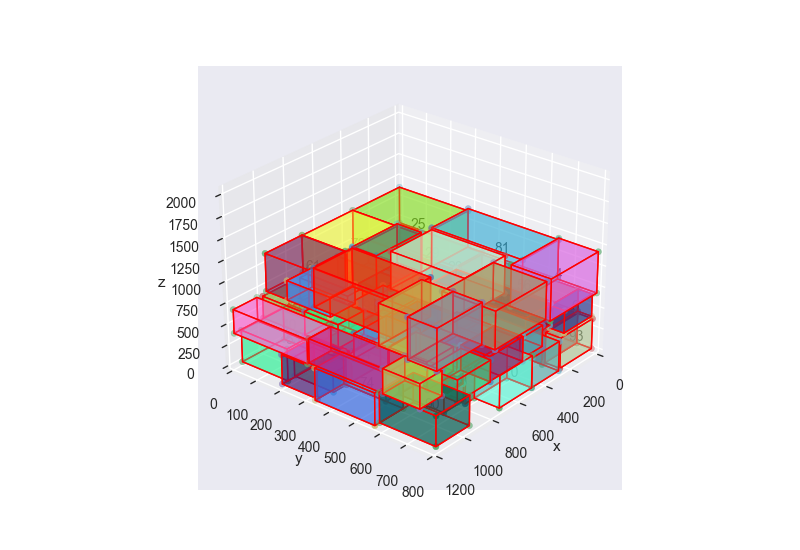

<IPython.core.display.Javascript object>

In [42]:
bin_pool.plot()
# print([b.layer_pool.get_ol() for b in bin_pool])
# print([l.superitems_pool for b in bin_pool for l in b.layer_pool])

## Column generation

- Dobbiamo passare a SP solo gli item con dual > 0?
- Dobbiamo evitare di processare layer con alpha != 1 (anche in SP no placement)?
- RMP lavora su tutti i layer, solo su quelli nuovi o su una parte?

In [64]:
order.iloc[[10, 17, 21, 46]]

,id,width,depth,height,weight,volume
10,870910,307,167,422,2,21635518
17,65725,324,98,472,2,14986944
21,905778,317,110,484,2,16877080
46,251995,307,187,387,39,22217283


<IPython.core.display.Javascript object>

In [70]:
bins_lbs = []
final_layer_pool = layers.LayerPool(superitems.SuperitemPool())
for i, spool in enumerate([height_groups[101]]):
    print(f"Height group {i + 1}/{len(height_groups)}")
    print(spool)
    layer_pool = warm_start.maxrects(spool, config.PALLET_DIMS, add_single=False)
    print(layer_pool)
    layer_pool, bins_lb = cg.column_generation(
        layer_pool,
        config.PALLET_DIMS,
        max_iter=100,
        max_stag_iters=5,
        tlim=None,
        use_maxrect=True,
    )
    final_layer_pool.extend(layer_pool)
    bins_lbs.append(bins_lb)

final_layer_pool.to_dataframe()

  5%|▌         | 5/100 [00:00<00:00, 246.50it/s]

Height group 1/103
SuperitemPool(superitems=[Superitem(ids=[10, 17, 21, 46], width=324, depth=187, height=1765, weight=45, volume=75716825, coords={10: Coordinate(x=8, y=10, z=0), 46: Coordinate(x=8, y=0, z=422), 21: Coordinate(x=3, y=38, z=809), 17: Coordinate(x=0, y=44, z=1293)})])
LayerPool(layers=[Layer(height=1765, ids=[10, 17, 21, 46])])
Solving RMP...
Duals: [1765.   -0.   -0.   -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 1766.0
Reduced cost: -0.0016987542469451
Solving RMP...
Duals: [  -0.   -0.   -0. 1765.]
Alpha: [1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 1766.0
Reduced cost: -0.0016987542469451
Solving RMP...
Duals: [  -0.   -0.   -0. 1765.]
Alpha: [1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 1766.0
Reduced cost: -0.0016987542469451
Solving RMP...
Duals: [  -0.   -0.   -0. 1765.]
Alpha: [1

,item,x,y,z,width,depth,height,layer
0,10,8,10,0,307,167,422,0
1,46,8,0,422,307,187,387,0
2,21,3,38,809,317,110,484,0
3,17,0,44,1293,324,98,472,0
4,10,8,10,0,307,167,422,1
5,46,8,0,422,307,187,387,1
6,21,3,38,809,317,110,484,1
7,17,0,44,1293,324,98,472,1
8,10,8,10,0,307,167,422,2
9,46,8,0,422,307,187,387,2


<IPython.core.display.Javascript object>

In [15]:
final_layer_pool = final_layer_pool.select_layers(
    config.PALLET_WIDTH, config.PALLET_DEPTH, min_density=0.0, max_coverage=3
)

<IPython.core.display.Javascript object>

In [16]:
final_layer_pool.to_dataframe()

,item,x,y,z,width,depth,height,layer
0,20,0,0,0,232,494,441,0
1,56,0,494,0,350,287,441,0
2,21,232,0,0,343,263,411,0
3,39,232,263,0,340,192,413,0
4,51,350,455,0,300,291,444,0
...,...,...,...,...,...,...,...,...
72,36,193,119,0,243,102,406,5
73,66,226,0,0,242,109,289,6
74,68,468,0,0,240,97,304,6
75,70,242,0,0,234,112,251,7


<IPython.core.display.Javascript object>

In [17]:
np.floor(np.mean(bins_lbs) / config.PALLET_HEIGHT)

0.0

<IPython.core.display.Javascript object>

In [18]:
bin_pool = pack.BinPool(final_layer_pool, config.PALLET_DIMS)
bin_pool.to_dataframe()

,item,x,y,z,width,depth,height,layer,bin
0,20,0,0,0,232,494,441,0,0
1,56,0,494,0,350,287,441,0,0
2,21,232,0,0,343,263,411,0,0
3,39,232,263,0,340,192,413,0,0
4,51,350,455,0,300,291,444,0,0
...,...,...,...,...,...,...,...,...,...
1,36,193,119,0,243,102,406,0,1
2,66,226,0,417,242,109,289,1,1
3,68,468,0,417,240,97,304,1,1
4,70,242,0,744,234,112,251,2,1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


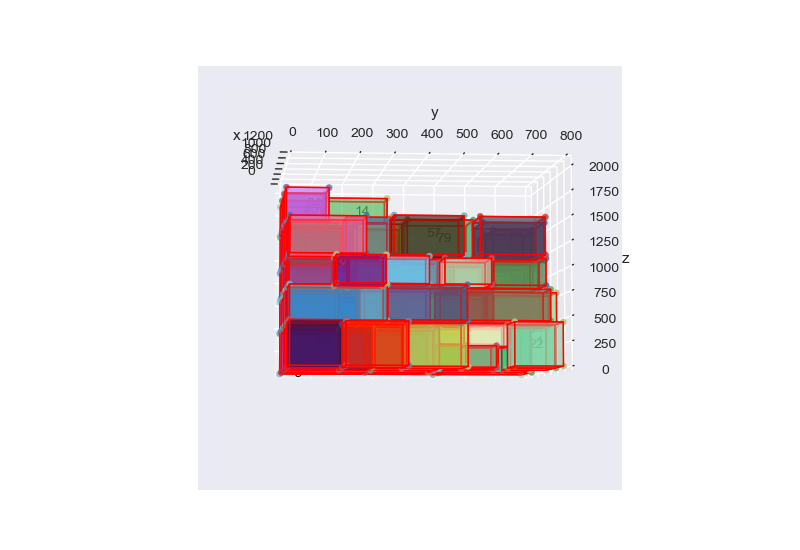

<IPython.core.display.Javascript object>


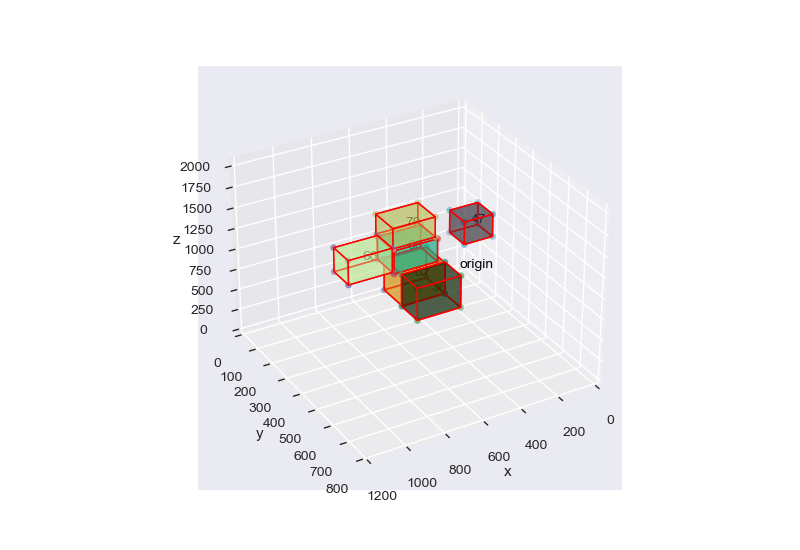

<IPython.core.display.Javascript object>

In [19]:
bin_pool.plot()

## Todo 

### Problemi in Input al modello:
- [ ] Correggere gestione superitem in Heigth groups
    - Problema riguardo stesso Item nello stesso Layer dovuto a superitem Horizontal nei 2 assi -> (Messo in pausa, per ora risolto usando solo Vertical e Single superitems)
    - Suddividere gruppi in piu gruppi 
        - Solo fra superitem con > 1 item e superitem con = 1 item
- [x] Eliminare gruppi con 1 solo item e gruppi con densita minore di 0.5
- [x] Creare Vertical Superitems consistenti alla loro dimensione principale (Da rivedere in caso di aggiunta rotazione, come tutto...)
- [x] Corretto calcolo volume Superitems e aggiunto enclosing_volume per Vertical Superitems
- [ ] Rivedere lower bound martello (L1 viene 0) (L0 viene sempre 1) (L2 non compi

### Problemi interni al modello:
- [x] Aggiunto reward in pricing_no_placement per incetivare la costruzione di layer più densi -> Con più item, quindi anche di item con Dual[i]==0, formula di reward con upper_bound = min(dual[i] !=0)
- [x] Modificato pricing placement (v2) per piazzare tutti gli item selezionati se possibile -> Molto lento con 13 item muore ma corretto rispetto a v1 che tendeva per costruzione a non piazzare tutta la sottoparte selezionata
- [x] Aggiunto maxrect placement per i nuovi layer del column generation

    
### Problemi in Output al modello:
- [ ] Aggiungere gestione Weigth a quella della Densità con qualche priorità e spiegazione annessa
- [x] Aggiungere gestione coordinate corretta per i Vertical Superitems, centrare gli oggetti nello spazio occupato
- [ ] Controllare select_layer e aggiungere flag per utilizzare solo subset di sottoprocess per testing
- [ ] Sostituire item rimossi in fase di select_layers con altri item non piazzati, usando maxrects
- [ ] Gestione Item rimanenti
    1. Piazzare gli ultimi item con algoritmo s-shape
    2. Provare a suddividere lo spazio rimanente in alto anche di layer incompleti in "Sotto pallet" ed usare maxrect su quelli (Magari funziona meglio)
- [ ] Gestione spaziatura 
    - Spaziatura intra-layer spiegata nel paper?
        1. 2 modelli di linear programming -> Spaziatura mediante modelli per width and depth dimensions
        2. Soluzione di spostamento monodirezionale iterativa dei blocchi di un layer (Da pensare per bene come alternativa a 1)
    - Spaziatura inter-layer in altezza
         1. Controllare spazi vuoti anche in altezza al termine di tutto usando una delle 2 tecnice sopradescritte
         
### Aggiunte eventuali
- [ ] Gestione rotazione
- [ ] Oggetti fragili -> Peso + attributi particolari
